## Hierarchical Clustering

In [1]:
import os
import spacy
from spacy import displacy
from collections import Counter
nlp = spacy.load("en_core_web_sm")
import pandas as pd
#from py_thesaurus import Thesaurus

import nltk
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come', 'seek', 'can', 'the', 'a', 'this', 'its', 'as', 'such', 'fund', 'investment', 'invest', 'asset', 'portfolio', 'equity', 'aim'])
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come', 'seek', 'can', 'the', 'a', 'this', 'its', 'as', 'such', 'invest', 'portfolio', 'aim'])
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import re

import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

In [3]:
kiid2table = pd.read_excel("./outputs/kiid8000/kiidoc2table.xlsx")
kiid2table.head()

Unnamed: 0                                          name_file  \
0           0  KIIDOC-2019-12-20-EN-CH-2020-01-06-157241-0900...   
1           0  KIIDOC-2020-02-19-EN-GB-2020-02-17-283156-0900...   
2           0  KIIDOC-2019-05-22-EN-00-2019-05-21-339044-0900...   
3           0  KIIDOC-2019-06-17-EN-00-2019-06-17-330896-0900...   
4           0  KIIDOC-2020-02-28-EN-GB-2020-02-28-358013-0900...   

    share_class                        subfund         umbrella_fund  \
0  LU0823429740                   India Equity     BNP Paribas Funds   
1  LU1664645287                           Aqua     BNP Paribas Funds   
2  LU1981115113  Invesco US Value Equity Fund        Invesco Funds     
3  LU1934329050     Invesco ASEAN Equity Fund         Invesco Funds    
4  LU2066071577                     SMaRT Food     BNP Paribas Funds   

                                          objectives  \
0    The Fund seeks to increase the value of its ...   
1    The Fund seeks to increase the value of its ...   
2    The objective of the Fund is to achieve long...   
3    The objective of the Fund is to achieve long...   
4    The Fund seeks to increase the value of its ...   

                                               risks  \
0    Lower risk Higher risk Other risks materiall...   
1    Lower risk Higher risk Other risks materiall...   
2    Other RisksLower Risk Higher Risk n The valu...   
3    Other RisksLower Risk Higher Risk n The valu...   
4    Lower risk Higher risk Other risks materiall...   

                                         description  \
0  Key Investor InformationThis document provides...   
1  Key Investor InformationThis document provides...   
2  Key Investor Information This document provide...   
3  Key Investor Information This document provide...   
4  Key Investor InformationThis document provides...   

                                                   0  
0   BNP PARIBAS ASSET MANAGEMENT Luxembourg, part...  
1   BNP PARIBAS ASSET MANAGEMENT Luxembourg, part...  
2   Invesco Management S.A., part of the Invesco ...  
3   Invesco Management S.A., part of the Invesco ...  
4   BNP PARIBAS ASSET MANAGEMENT Luxembourg, part...

In [4]:
kiid2terms = pd.read_excel("./outputs/kiid8000/kiidoc2terms.xlsx")
kiid2terms.head()

Unnamed: 0  # type                                 key  pattern Unnamed: 5  \
0           0  1    T                 nn: investment team      N N        NaN   
1           1  2    T              nnn: bank business day    N N N        NaN   
2           2  3    T   annn: bnp pariba asset management  A N N N        NaN   
3           3  4    T             npn: investment of fund    N P N        NaN   
4           4  5    T  ann: sustainable investment policy    A N N        NaN   

                           pilot  spec  freq  dFreq   ind semScore  isDico  \
0                investment team  5,10  2531   2447  0,98      NaN     NaN   
1             bank business days  5,09  2471   2460  1,00      NaN     NaN   
2   BNP PARIBAS ASSET MANAGEMENT  5,08  2456   2456  1,00      NaN     NaN   
3        investments of the Fund  5,08  2447   2447  0,99      NaN     NaN   
4  Sustainable Investment Policy  5,07  2375   2375  0,13      NaN     NaN   

   isDistrib Parent concept Property concept Unnamed: 16  entity  entity2  \
0        NaN            NaN              NaN         NaN     NaN      NaN   
1        NaN            NaN              NaN         NaN     NaN      NaN   
2        NaN            NaN              NaN         NaN     NaN      NaN   
3        NaN            NaN              NaN         NaN     NaN      NaN   
4        NaN            NaN              NaN         NaN     NaN      NaN   

                                         kiidoc_list  
0  ['LU0823438816', 'LU1956155193', 'LU1920352793...  
1  ['LU0823438816', 'LU1956155193', 'LU1920352793...  
2  ['LU0823438816', 'LU1956155193', 'LU1920352793...  
3  ['LU0823438816', 'LU1956155193', 'LU1920352793...  
4  ['LU0823438816', 'LU1956155193', 'LU1920352793...

In [5]:
subfund = [sub for sub in kiid2table.loc[:,"subfund"]]

In [53]:
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
"""
from stop_words import get_stop_words

stop_words = get_stop_words('en')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

SPACE_REPLACEMENT = re.compile('[/(){}\[\]\|@,;]')
SYMBOLS = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
pattern = r'''(?x)     # set flag to allow verbose regexps
     (?:[A-Z]\.)+       # abbreviations, e.g. U.S.A.
   | \w+(?:-\w+)*       # words with optional internal hyphens
   | \$?\d+(?:\.\d+)?%? # currency and percentages, e.g. $12.40, 82%
   | \.\.\.             # ellipsis
   | [][.,;"'?():-_`]   # these are separate tokens; includes ], [
 '''
#to be deleted: 2/2, 
"""

'\nfrom stop_words import get_stop_words\n\nstop_words = get_stop_words(\'en\')\nfrom nltk.stem import WordNetLemmatizer\nlemmatizer = WordNetLemmatizer()\n\nSPACE_REPLACEMENT = re.compile(\'[/(){}\\[\\]\\|@,;]\')\nSYMBOLS = re.compile(\'[^0-9a-z #+_]\')\nSTOPWORDS = set(stopwords.words(\'english\'))\npattern = r\'\'\'(?x)     # set flag to allow verbose regexps\n     (?:[A-Z]\\.)+       # abbreviations, e.g. U.S.A.\n   | \\w+(?:-\\w+)*       # words with optional internal hyphens\n   | \\$?\\d+(?:\\.\\d+)?%? # currency and percentages, e.g. $12.40, 82%\n   | \\.\\.\\.             # ellipsis\n   | [][.,;"\'?():-_`]   # these are separate tokens; includes ], [\n \'\'\'\n#to be deleted: 2/2, \n'

In [99]:
texts = [text for text in kiid2table.loc[:,"objectives"]]

In [102]:
new_text = []
terms = [term for term in kiid2terms.loc[:,"pilot"]]
terms = [term for term in word_tokenize(str(terms))]
#print(terms)

for text in texts:
    text = [word for word in word_tokenize(text)]
    res = [i for i in text if i in terms] 
    new_text.append(res)
print(new_text[0])


['Fund', 'the', 'value', 'of', 'assets', 'the', 'term', 'in', 'shares', 'Indian', 'companies', ',', 'or', 'companies', 'in', 'country', 'is', 'and', 'in', 'securities', 'are', 'in', 'the', 'index', 'is', 'MSCI', 'USD', 'investment', 'team', 'PARIBAS', 'ASSET', 'MANAGEMENT', 'Investment', 'Policy', ',', ',', 'and', 'criteria', 'in', 'the', 'investments', 'of', 'the', 'Fund', 'Income', 'are', 'are', 'a', 'basis', 'bank', 'business', 'days']


In [72]:
term_4_tfidf = [' '.join(str(word) for word in text) for text in new_text]

## TFIDF with terms

### Construct a document-term matrix:
list of document/subfund as rows and list of terms as column. for each term, calculate tfidf.

In [12]:
# string of terms

term_4_tfidf = [' '.join(str(word) for word in text) for text in kiid2term]

In [13]:
print(term_4_tfidf[0])

investment team bank business days BNP PARIBAS ASSET MANAGEMENT investments of the Fund Sustainable Investment Policy Mainland China shares specific license Chinese authorities Investment Policy Quantitative methods rating agency basis points registered offices Water Infrastructure investment horizon of the sub-fund category of money market funds flexible and diversified allocation strategy tradable equities systematic initiative LIBID digitization medium sized Japanese companies reasonable level of income pure alpha market currencies performance of the Equity Basket highest possible credit rating assets of the sub-fund BenchmarkInvestment Policy predefined thresholds 3-month USD LIBOR German companies environmental criteria international markets indirectly futures markets environmental projects high income fundamentals Poor inside technique


### Clean and tokenize text

In [8]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = kiid2table.objectives.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['the', 'fund', 'seeks', 'to', 'increase', 'the', 'value', 'of', 'its', 'assets', 'over', 'the', 'medium', 'term', 'by', 'investing', 'in', 'shares', 'issued', 'by', 'indian', 'companies', 'or', 'companies', 'operating', 'in', 'this', 'country', 'it', 'is', 'actively', 'managed', 'and', 'as', 'such', 'may', 'invest', 'in', 'securities', 'that', 'are', 'not', 'included', 'in', 'the', 'index', 'which', 'is', 'msci', 'india', 'usd', 'nr', 'the', 'investment', 'team', 'applies', 'also', 'bnp', 'paribas', 'asset', 'management', 'sustainable', 'investment', 'policy', 'which', 'takes', 'into', 'account', 'environmental', 'social', 'and', 'governance', 'esg', 'criteria', 'in', 'the', 'investments', 'of', 'the', 'fund', 'income', 'are', 'systematically', 'reinvested', 'investors', 'are', 'able', 'to', 'redeem', 'on', 'daily', 'basis', 'on', 'luxembourg', 'bank', 'business', 'days']]


In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [12]:
data_ready = [' '.join(str(word) for word in text) for text in data_ready]

## Clustering

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

vec = TfidfVectorizer(stop_words='english', lowercase=True, min_df=0.2, ngram_range=(1,3), use_idf=True)
vec.fit(data_ready)
features = vec.transform(data_ready)
data_scaled = pd.DataFrame(vec.transform(data_ready).toarray(), columns=sorted(vec.vocabulary_.keys()))
data_scaled

able  able redeem  able redeem daily   account  \
0     0.094668     0.095768           0.095768  0.095768   
1     0.096438     0.097559           0.097559  0.097559   
2     0.000000     0.000000           0.000000  0.000000   
3     0.000000     0.000000           0.000000  0.000000   
4     0.089593     0.090634           0.090634  0.090634   
...        ...          ...                ...       ...   
2123  0.000000     0.000000           0.000000  0.000000   
2124  0.000000     0.000000           0.000000  0.000000   
2125  0.000000     0.000000           0.000000  0.000000   
2126  0.000000     0.000000           0.000000  0.000000   
2127  0.084391     0.085372           0.085372  0.085372   

      account environmental  account environmental social   achieve  \
0                  0.095768                      0.095768  0.000000   
1                  0.097559                      0.097559  0.000000   
2                  0.000000                      0.000000  0.133545   
3                  0.000000                      0.000000  0.127430   
4                  0.090634                      0.090634  0.000000   
...                     ...                           ...       ...   
2123               0.000000                      0.000000  0.065263   
2124               0.000000                      0.000000  0.131510   
2125               0.000000                      0.000000  0.127375   
2126               0.000000                      0.000000  0.124685   
2127               0.085372                      0.085372  0.000000   

      achieve long  achieve long term  actively  ...  term share issue  \
0         0.000000           0.000000  0.058008  ...          0.146236   
1         0.000000           0.000000  0.059092  ...          0.148971   
2         0.190377           0.190377  0.077164  ...          0.000000   
3         0.181660           0.181660  0.073630  ...          0.000000   
4         0.000000           0.000000  0.054898  ...          0.138397   
...            ...                ...       ...  ...               ...   
2123      0.000000           0.000000  0.037709  ...          0.000000   
2124      0.187476           0.187476  0.075988  ...          0.000000   
2125      0.181581           0.181581  0.073598  ...          0.000000   
2126      0.177746           0.177746  0.072044  ...          0.000000   
2127      0.000000           0.000000  0.051711  ...          0.000000   

         value  value actively  value actively manage  value medium  \
0     0.074557        0.000000               0.000000      0.101787   
1     0.075951        0.000000               0.000000      0.103690   
2     0.000000        0.000000               0.000000      0.000000   
3     0.000000        0.000000               0.000000      0.000000   
4     0.070559        0.000000               0.000000      0.096330   
...        ...             ...                    ...           ...   
2123  0.048467        0.092879               0.092879      0.000000   
2124  0.000000        0.000000               0.000000      0.000000   
2125  0.000000        0.000000               0.000000      0.000000   
2126  0.000000        0.000000               0.000000      0.000000   
2127  0.000000        0.000000               0.000000      0.000000   

      value medium term    vary  vary leverage  vary leverage gain  worldwide  
0              0.101787  0.0000       0.000000            0.000000   0.000000  
1              0.103690  0.0000       0.000000            0.000000   0.000000  
2              0.000000  0.0000       0.000000            0.000000   0.000000  
3              0.000000  0.0000       0.000000            0.000000   0.000000  
4              0.096330  0.0000       0.000000            0.000000   0.000000  
...                 ...     ...            ...                 ...        ...  
2123           0.000000  0.0895       0.092722            0.092722   0.087817  
2124           0.000000  0.0000       0.000000        

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(data_scaled)
print(len(dist))

2128


In [15]:
num_clusters=5
cls = MiniBatchKMeans(n_clusters=num_clusters)
cls.fit(features)
clusters = cls.labels_.tolist()

In [16]:
texts = data_ready

In [17]:

films = { 'subfund': subfund, 'objective': texts, 'cluster': clusters}

frame = pd.DataFrame(films, index = [clusters] , columns = ['subfund', 'cluster'])

In [77]:
frame2 = frame.set_index('subfund')

In [18]:

frame['cluster'].value_counts() #number of subfund per cluster (clusters from 0 to 4)

2    558
0    478
4    443
3    419
1    230
Name: cluster, dtype: int64

In [79]:
frame2.sort_values(by=['cluster'])

cluster
subfund              
LU1380457819        0
LU1603800555        0
LU0955867758        0
LU2065167715        0
LU1097689019        0
...               ...
LU1721430160        3
LU0111550652        3
LU0823389183        3
LU0282389757        3
LU1695654068        3

[2128 rows x 1 columns]

In [19]:
# reduce the features to 2D
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

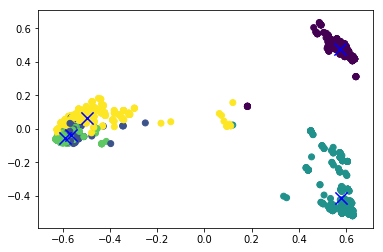

In [20]:
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

In [21]:
from sklearn.metrics import silhouette_score
silhouette_score(features, labels=cls.predict(features))

0.34852005233429467

In [22]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=10, metric='cosine')
knn.fit(features)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=None, n_neighbors=10, p=2, radius=1.0)

In [272]:
with open('./terminology/kiid_obj/output/kiid_obj/kiidoc2obj1867.txt') as text1:
    text1 = text1.read()
with open('./terminology/kiid_obj/output/kiid_obj/kiidoc2obj2457.txt') as text2:
    text2 = text2.read()

In [273]:
input_texts = [text1, text2]
input_features = vec.transform(input_texts)

D, N = knn.kneighbors(input_features, n_neighbors=2, return_distance=True)

for input_text, distances, neighbors in zip(input_texts, D, N):
    print("Input text = ", input_text[:200], "\n")
    for dist, neighbor_idx in zip(distances, neighbors):
        print("Distance = ", dist, "Neighbor idx = ", neighbor_idx)
        print(texts[neighbor_idx][:200])
        print("-"*200)
    print("="*200)
    print()

Input text =  Objectives and Investment Policy The Fund seeks to increase the value of its assets over the medium term by investing in shares undervalued as compared to the market on the purchase date, issued by US 

Distance =  0.32264153237769777 Neighbor idx =  164
increase value medium term share undervalue compare market purchase date issue company company operate country build base systematic approach combine several factor criterion value quality low volatil
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Distance =  0.32264153237769777 Neighbor idx =  390
increase value medium term share undervalue compare market purchase date issue company company operate country build base systematic approach combine several factor criterion value quality low volatil
----------------------------------------------------------------------------

## Hierarchical Clustering

In [255]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='ward')  
cluster.fit_predict(data_scaled)

array([4, 7, 1, ..., 1, 1, 0])

In [26]:
dir_out = input("Enter your directory for hierarchical clustering outputs: ")

Enter your directory for hierarchical clustering outputs: ./outputs/clustering/


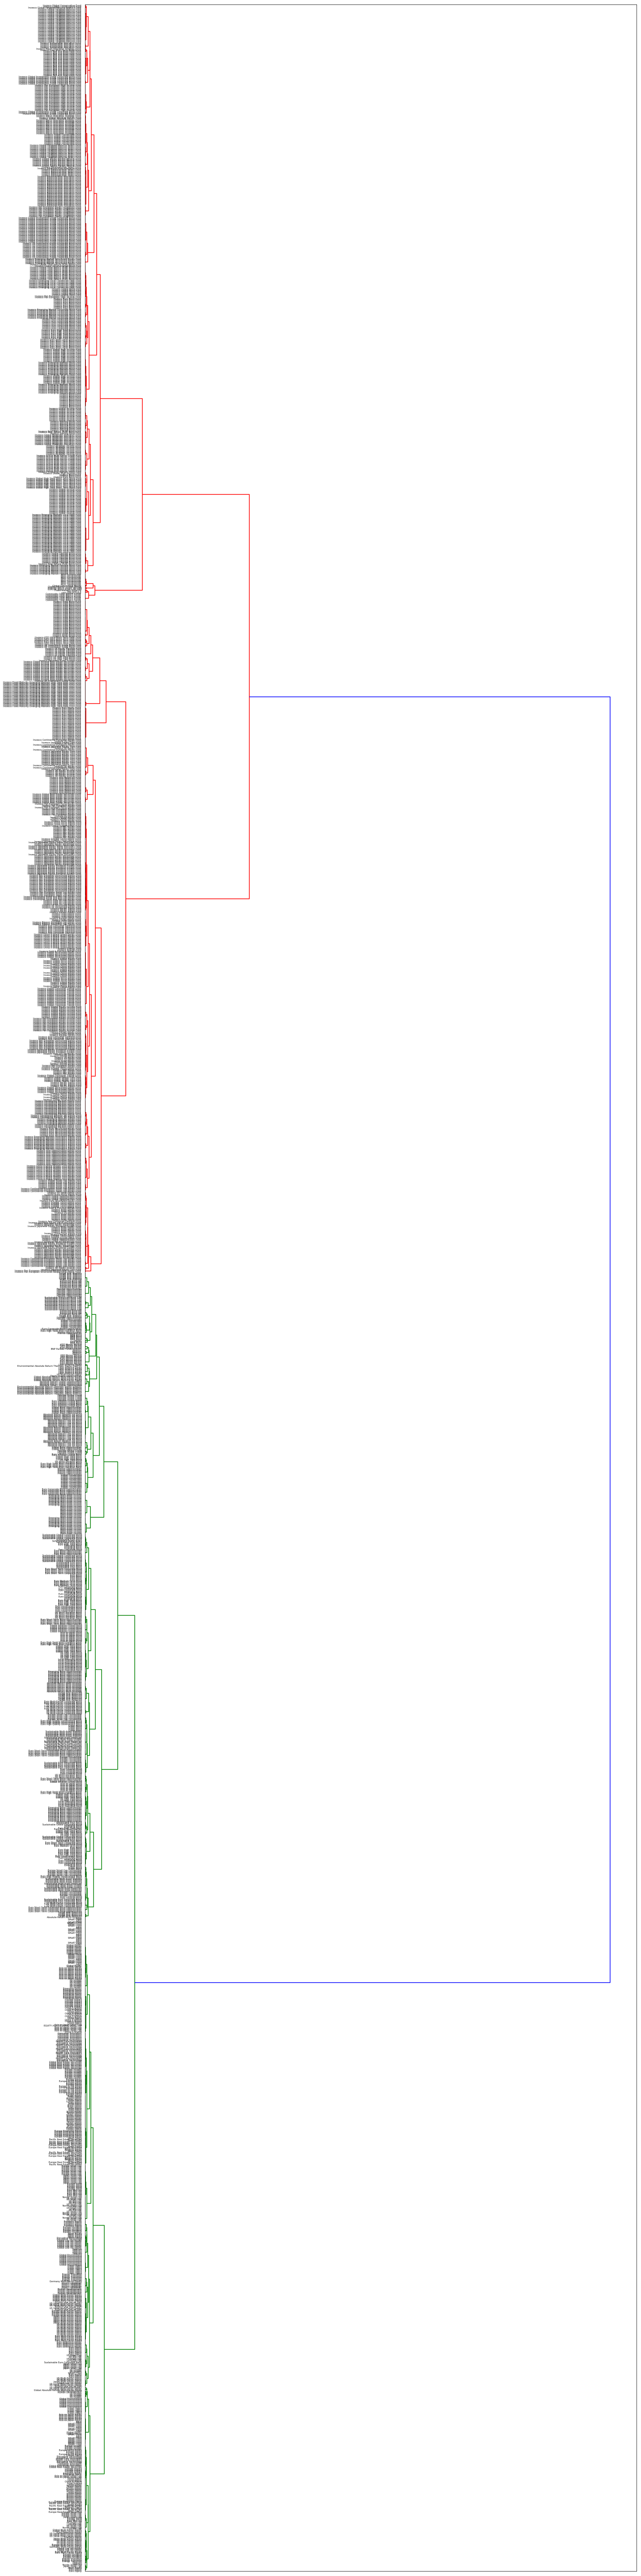

In [27]:

from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(20, 80)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=subfund);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off',
    labelsize=12)

plt.savefig(dir_out+'ward_clusters.png', dpi=200)
plt.tight_layout() #show plot with tight layout

In [28]:
plt.close()

In [72]:
kiid_terms_list = []
term_list = kiid2terms.loc[:, "pilot"]

kiid_terms2 = [kiid2table.objectives.str.findall(term, flags=re.IGNORECASE) for term in kiid2terms.loc[:,"pilot"]]

print(kiid_terms2)


[0       [investment team]
1       [investment team]
2                      []
3                      []
4       [investment team]
              ...        
2123                   []
2124                   []
2125                   []
2126                   []
2127    [investment team]
Name: objectives, Length: 2128, dtype: object, 0       [bank business days]
1       [bank business days]
2                         []
3                         []
4       [bank business days]
                ...         
2123                      []
2124                      []
2125                      []
2126                      []
2127    [bank business days]
Name: objectives, Length: 2128, dtype: object, 0       [BNP PARIBAS ASSET MANAGEMENT]
1       [BNP PARIBAS ASSET MANAGEMENT]
2                                   []
3                                   []
4       [BNP PARIBAS ASSET MANAGEMENT]
                     ...              
2123                                []
2124                       

In [11]:
df_terms_gensim = pd.DataFrame(kiid_terms2)
df_terms_gensim

0                                1     \
objectives                [investment team]                [investment team]   
objectives             [bank business days]             [bank business days]   
objectives   [BNP PARIBAS ASSET MANAGEMENT]   [BNP PARIBAS ASSET MANAGEMENT]   
objectives        [investments of the Fund]        [investments of the Fund]   
objectives  [Sustainable Investment Policy]  [Sustainable Investment Policy]   
...                                     ...                              ...   
objectives                               []                               []   
objectives                               []                               []   
objectives                               []                               []   
objectives                               []                               []   
objectives                               []                               []   

           2    3                                4    5     \
objectives   []   []                [investment team]   []   
objectives   []   []             [bank business days]   []   
objectives   []   []   [BNP PARIBAS ASSET MANAGEMENT]   []   
objectives   []   []        [investments of the Fund]   []   
objectives   []   []  [Sustainable Investment Policy]   []   
...         ...  ...                              ...  ...   
objectives   []   []                               []   []   
objectives   []   []                               []   []   
objectives   []   []                               []   []   
objectives   []   []                               []   []   
objectives   []   []                               []   []   

                                       6    7     \
objectives                [investment team]   []   
objectives             [bank business days]   []   
objectives   [BNP PARIBAS ASSET MANAGEMENT]   []   
objectives        [investments of the Fund]   []   
objectives  [Sustainable Investment Policy]   []   
...                                     ...  ...   
objectives                               []   []   
objectives                               []   []   
objectives                               []   []   
objectives                               []   []   
objectives                               []   []   

                                       8                                9     \
objectives                [investment team]                [investment team]   
objectives             [bank business days]             [bank business days]   
objectives   [BNP PARIBAS ASSET MANAGEMENT]   [BNP PARIBAS ASSET MANAGEMENT]   
objectives        [investments of the Fund]        [investments of the Fund]   
objectives  [Sustainable Investment Policy]  [Sustainable Investment Policy]   
...                                     ...                              ...   
objectives                               []                               []   
objectives                               []                               []   
objectives                               []                               []   
objectives                               []                               []   
objectives                               []                               []   

            ... 2118 2119 2120                             2121 2122 2123  \
objectives  ...   []   []   []                [investment team]   []   []   
objectives  ...   []   []   []             [bank business days]   []   []   
objectives  ...   []   []   []   [BNP PARIBAS ASSET MANAGEMENT]   []   []   
objectives  ...   []   []   []        [investments of the Fund]   []   []   
objectives  ...   []   []   []  [Sustainable Investment Policy]   []   []   
...         ...  ...  ...  ...                              ...  ...  ...   
objectives  ...   []   []   []                               []   []   []   
objectives  ...   []   []   []                               []   []   []   
objectives  ...   []   []   []                        

In [12]:
df_terms_gensim.columns = [isin for isin in kiid2table.loc[:,"share_class"]]
df_terms_gensim.index = [term for term in kiid2terms.loc[:, "pilot"]]
df_terms_gensim.head()

LU0823429740  \
investment team                              [investment team]   
bank business days                        [bank business days]   
BNP PARIBAS ASSET MANAGEMENT    [BNP PARIBAS ASSET MANAGEMENT]   
investments of the Fund              [investments of the Fund]   
Sustainable Investment Policy  [Sustainable Investment Policy]   

                                                  LU1664645287 LU1981115113  \
investment team                              [investment team]           []   
bank business days                        [bank business days]           []   
BNP PARIBAS ASSET MANAGEMENT    [BNP PARIBAS ASSET MANAGEMENT]           []   
investments of the Fund              [investments of the Fund]           []   
Sustainable Investment Policy  [Sustainable Investment Policy]           []   

                              LU1934329050                     LU2066071577  \
investment team                         []                [investment team]   
bank business days                      []             [bank business days]   
BNP PARIBAS ASSET MANAGEMENT            []   [BNP PARIBAS ASSET MANAGEMENT]   
investments of the Fund                 []        [investments of the Fund]   
Sustainable Investment Policy           []  [Sustainable Investment Policy]   

                              LU1218207659                     LU1789409452  \
investment team                         []                [investment team]   
bank business days                      []             [bank business days]   
BNP PARIBAS ASSET MANAGEMENT            []   [BNP PARIBAS ASSET MANAGEMENT]   
investments of the Fund                 []        [investments of the Fund]   
Sustainable Investment Policy           []  [Sustainable Investment Policy]   

                              LU1814057086                     LU1596575826  \
investment team                         []                [investment team]   
bank business days                      []             [bank business days]   
BNP PARIBAS ASSET MANAGEMENT            []   [BNP PARIBAS ASSET MANAGEMENT]   
investments of the Fund                 []        [investments of the Fund]   
Sustainable Investment Policy           []  [Sustainable Investment Policy]   

                                                  LU0823429153  ...  \
investment team                              [investment team]  ...   
bank business days                        [bank business days]  ...   
BNP PARIBAS ASSET MANAGEMENT    [BNP PARIBAS ASSET MANAGEMENT]  ...   
investments of the Fund              [investments of the Fund]  ...   
Sustainable Investment Policy  [Sustainable Investment Policy]  ...   

                              LU1502200097 LU2110298895 LU1564318266  \
investment team                         []           []           []   
bank business days                      []           []           []   
BNP PARIBAS ASSET MANAGEMENT            []           []           []   
investments of the Fund                 []           []           []   
Sustainable Investment Policy           []           []           []   

                                                  LU1022404138 LU1642787359  \
investment team                              [investment team]           []   
bank business days                        [bank business days]           []   
BNP PARIBAS ASSET MANAGEMENT    [BNP PARIBAS ASSET MANAGEMENT]           []   
investments of the Fund              [investments of the Fund]           []   
Sustainable Investment Policy  [Sustainable Investment Policy]           []   

                              LU1603801363 LU1701697515 LU1218206925  \
investment team                         []           []           []   
bank business days                      []           []           []   
BNP PARIBAS ASSET MANAGEMENT            []           []           []   
investments of the Fund                 []           []           []   
Sustainable Investment Policy           []           []   

In [13]:
df_terms_gensim = df_terms_gensim.astype(str)
df_terms_gensim = df_terms_gensim.replace(to_replace=r"\[|\]|\'", value='', regex=True)
#df_terms_gensim = df_terms_gensim.replace(to_replace=r'', value=None, regex=True)
df_terms_gensim

LU0823429740  \
investment team                              investment team   
bank business days                        bank business days   
BNP PARIBAS ASSET MANAGEMENT    BNP PARIBAS ASSET MANAGEMENT   
investments of the Fund              investments of the Fund   
Sustainable Investment Policy  Sustainable Investment Policy   
...                                                      ...   
aware                                                          
deals                                                          
Directors                                                      
board                                                          
weeks                                                          

                                                LU1664645287 LU1981115113  \
investment team                              investment team                
bank business days                        bank business days                
BNP PARIBAS ASSET MANAGEMENT    BNP PARIBAS ASSET MANAGEMENT                
investments of the Fund              investments of the Fund                
Sustainable Investment Policy  Sustainable Investment Policy                
...                                                      ...          ...   
aware                                                                       
deals                                                                       
Directors                                                                   
board                                                                       
weeks                                                                       

                              LU1934329050                   LU2066071577  \
investment team                                           investment team   
bank business days                                     bank business days   
BNP PARIBAS ASSET MANAGEMENT                 BNP PARIBAS ASSET MANAGEMENT   
investments of the Fund                           investments of the Fund   
Sustainable Investment Policy               Sustainable Investment Policy   
...                                    ...                            ...   
aware                                                                       
deals                                                                       
Directors                                                                   
board                                                                       
weeks                                                                       

                              LU1218207659                   LU1789409452  \
investment team                                           investment team   
bank business days                                     bank business days   
BNP PARIBAS ASSET MANAGEMENT                 BNP PARIBAS ASSET MANAGEMENT   
investments of the Fund                           investments of the Fund   
Sustainable Investment Policy               Sustainable Investment Policy   
...                                    ...                            ...   
aware                                                                       
deals                                                                       
Directors                                                                   
board                                                                       
weeks                                                                       

                              LU1814057086                   LU1596575826  \
investment team                                           investment team   
bank business days                                     bank business days   
BNP PARIBAS ASSET MANAGEMENT                 BNP PARIBAS ASSET MANAGEMENT   
investments of the Fund                           investments of the Fund   
Sustainable Investment Policy               Sustainable Investment Policy   
...                                    ...

In [19]:
df_terms_gensim.head(10)

LU0823429740  \
investment team                                 investment team   
bank business days                           bank business days   
BNP PARIBAS ASSET MANAGEMENT       BNP PARIBAS ASSET MANAGEMENT   
investments of the Fund                 investments of the Fund   
Sustainable Investment Policy     Sustainable Investment Policy   
Objectives and Investment Policy                                  
objective of the Fund                                             
debt instruments                                                  
structured debt instruments                                       
equivalent debt instruments                                       

                                                   LU1664645287  \
investment team                                 investment team   
bank business days                           bank business days   
BNP PARIBAS ASSET MANAGEMENT       BNP PARIBAS ASSET MANAGEMENT   
investments of the Fund                 investments of the Fund   
Sustainable Investment Policy     Sustainable Investment Policy   
Objectives and Investment Policy                                  
objective of the Fund                                             
debt instruments                                                  
structured debt instruments                                       
equivalent debt instruments                                       

                                           LU1981115113  \
investment team                                           
bank business days                                        
BNP PARIBAS ASSET MANAGEMENT                              
investments of the Fund                                   
Sustainable Investment Policy                             
Objectives and Investment Policy                          
objective of the Fund             objective of the Fund   
debt instruments                                          
structured debt instruments                               
equivalent debt instruments                               

                                           LU1934329050  \
investment team                                           
bank business days                                        
BNP PARIBAS ASSET MANAGEMENT                              
investments of the Fund                                   
Sustainable Investment Policy                             
Objectives and Investment Policy                          
objective of the Fund             objective of the Fund   
debt instruments                                          
structured debt instruments                               
equivalent debt instruments                               

                                                   LU2066071577  \
investment team                                 investment team   
bank business days                           bank business days   
BNP PARIBAS ASSET MANAGEMENT       BNP PARIBAS ASSET MANAGEMENT   
investments of the Fund                 investments of the Fund   
Sustainable Investment Policy     Sustainable Investment Policy   
Objectives and Investment Policy                                  
objective of the Fund                                             
debt instruments                                                  
structured debt instruments                                       
equivalent debt instruments                                       

                                                        LU1218207659  \
investment team                                                        
bank business days                                                     
BNP PARIBAS ASSET MANAGEMENT                                           
investments of the Fund                                                
Sustainable Investment Policy                                          
Objectives and Investment Policy                                       
objective of the Fund            

In [14]:
term_list = []
for col in df_terms_gensim.columns:
    term_list.append(list(df_terms_gensim.loc[:, col]))

clean_term_list = []
for elem in term_list:
    elem = list(filter(None, elem)) 
    elem = [term.lower() for term in elem]
    clean_term_list.append(elem)
print(clean_term_list[1])

['investment team', 'bank business days', 'bnp paribas asset management', 'investments of the fund', 'sustainable investment policy', 'mainland china shares', 'specific license', 'chinese authorities', 'investment policy', 'earnings growth', 'msci world', 'governance', 'related sectors', 'daily basis', 'medium term', 'financial structure', 'foreign investors', 'environmental', 'actively', 'social', 'criteria', 'assets', 'fund, fund', 'index', 'esg criteria', 'investors, investors', 'securities', 'china, china', 'account', 'shares, shares, shares', 'dividend', 'stock', 'luxembourg', 'structure', 'potential', 'quality', 'companies', 'investing', 'world', 'sector']


In [15]:
texts = [[word for word in text] for text in clean_term_list]

In [16]:
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
texts = [[lemmatizer.lemmatize(str(token)) for token in text] for text in texts]

In [17]:
print(texts[5])

['objective of the fund', 'debt instruments, debt instruments', 'complex instruments', 'shares of companies', 'investment objectives', 'asset value of the fund', 'amounts of leverage', 'fund gains market exposure', 'additional capital', 'significant use of derivatives', 'excess of the net asset', 'distressed securities', 'financial distress', 'money market instruments', 'positive total return', 'asset types', 'diversified portfolio', 'global equities', 'euribor', 'gross return', 'broad range of investment ideas', 'volatility target', 'prudent spread of risk', 'selection of assets', 'positive return', 'individual investment ideas', 'economic sectors', 'equivalent reference rate', 'volatility of global equities', 'month euribor', 'diversified', 'benchmark', 'actively', 'prospectus', 'objectives, objectives', 'net asset', 'derivative', 'volatility, volatility', 'year period, year period', 'asset', 'fund, fund, fund, fund, fund, fund, fund, fund, fund, fund, fund, fund', 'global', 'exposur

## LSA with SVD

## TFIDF with terms

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
#documents = ["doc1.txt", "doc2.txt", "doc3.txt"] 
  
# raw documents to tf-idf matrix: 
vectorizer = TfidfVectorizer(stop_words='english', 
                             use_idf=True, 
                             smooth_idf=True)
# SVD to reduce dimensionality: 
svd_model = TruncatedSVD(n_components=100,         #num dimensions
                         algorithm='randomized',
                         n_iter=10)
# pipeline of tf-idf + SVD, fit to and applied to documents:
svd_transformer = Pipeline([('tfidf', vectorizer), 
                            ('svd', svd_model)])
svd_matrix = svd_transformer.fit_transform(term_4_tfidf)

# svd_matrix can later be used to compare documents, compare words, or compare queries with documents

In [81]:
print(svd_matrix)

[[ 5.51711756e-01 -3.00680820e-01 -1.35908573e-01 ...  2.10910232e-02
   9.75579720e-03 -1.94043196e-02]
 [ 5.63862782e-01 -2.65323706e-01 -1.34912320e-02 ... -1.78911180e-05
   1.98152256e-02  9.97440390e-03]
 [ 5.63109001e-01 -3.49694422e-01 -1.07435261e-01 ...  9.59950596e-03
  -1.01810822e-02 -3.23887620e-03]
 ...
 [ 3.23943745e-01  3.29888181e-01 -1.00781544e-01 ... -2.96356154e-02
   4.18483083e-03  6.56226562e-02]
 [ 5.98896293e-01 -2.96068992e-01  4.07452402e-02 ...  1.47371412e-02
   5.72807940e-02 -1.57500593e-02]
 [ 6.35200254e-01  5.17352506e-01  2.58813926e-01 ...  3.38024489e-02
   3.79685139e-02 -2.36690670e-02]]
